In [8]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_error, mean_squared_error
from xgboost import XGBClassifier, XGBRegressor
import warnings
import random
import matplotlib.pyplot as plt

## Some utility functions to print out reports 

In [3]:
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

def print_regression_report(y_val, y_pred, fold):
    print(f'Fold: {fold}')
    print('Mean absolute error:', mean_absolute_error(y_val, y_pred))
    print('Mean squared error:', mean_squared_error(y_val, y_pred))
    print('Root Mean squared error:', np.sqrt(mean_squared_error(y_val, y_pred)))

def print_classification_report(y_val, y_pred, fold):
    print(f'Fold: {fold}')
    print(f'Accuracy Score: {accuracy_score(y_val, y_pred)}')
    print(f'Confusion Matrix: \n {confusion_matrix(y_val, y_pred)}')
    print(f'Classification Report: \n {classification_report(y_val, y_pred)}')

def print_multilabel_classification_report(y_val, y_pred, fold):
    print(f'Fold: {fold}')
    print(f'Accuracy Score: {accuracy_score(y_val, y_pred)}')
    print(f'Confusion Matrix: \n {confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))}')
    print(f'Classification Report: \n {classification_report(y_val, y_pred)}')



## Data Preview

   reviewer_id  store_name              category  \
0            1  McDonald's  Fast food restaurant   

                                       store_address  latitude   longitude  \
0  13749 US-183 Hwy, Austin, TX 78750, United States  30.460718 -97.792874   

  rating_count   review_time  \
0        1,240  3 months ago   

                                              review  rating  
0  Why does it look like someone spit on my food?...  1 star  
reviewer_id        int64
store_name        object
category          object
store_address     object
latitude         float64
longitude        float64
rating_count      object
review_time       object
review            object
rating            object
dtype: object


<AxesSubplot:>

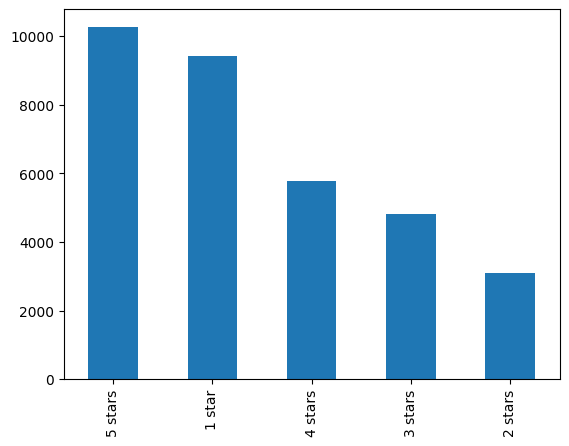

In [41]:
# data set preview
data = pd.read_csv('datasets/mcdonald_reviews/McDonald_s_Reviews.csv', encoding='latin-1')
print(data.head(1))
print(data.dtypes)

rating_counts = data['rating'].value_counts()
rating_counts.plot(kind='bar')

## Positive - Negative classification

Here, I stripped all 3-stars labels and only keep 4 and 5 as positive, and 1-2 as negative.
There is another submission that used transformer with 90% accuracy.
Here, we get around > 93% accuracy for this formulation using 5-fold cross validation.

In [42]:
def read_data_positive_negative_only(file_path):
    data = pd.read_csv(file_path, encoding='latin-1')
    data.dropna(inplace=True)
    mask = data['rating'] != '3 stars'
    filtered_data = data[mask]
    data = filtered_data

    label_encoder = LabelEncoder()
    T_vectorizer = CountVectorizer(ngram_range=(1, 3), max_features=10000)

    X = data['review'].values
    y = data['rating'].values

    for i in range(len(y)):
        if y[i] == '1 star':
            y[i] = 0
        elif y[i] == '2 stars':
            y[i] = 0
        elif y[i] == '4 stars':
            y[i] = 1
        elif y[i] == '5 stars':
            y[i] = 1

    X = T_vectorizer.fit_transform(X)
    y = label_encoder.fit_transform(y)
    return X, y

X, y = read_data_positive_negative_only('datasets/mcdonald_reviews/McDonald_s_Reviews.csv')
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# k-fold experiment using XGBoost
fold = 1

for train_index, val_index in kfold.split(X):

  X_train, X_val = X[train_index], X[val_index]
  y_train, y_val = y[train_index], y[val_index]

  model = XGBClassifier(n_estimators=2500, learning_rate=0.3, max_depth=5, colsample_bytree=0.3, n_jobs=-1, random_state=42)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_val)

  print_classification_report(y_val, y_pred, fold)
  fold += 1



Fold: 1
Accuracy Score: 0.9322154834106314
Confusion Matrix: 
 [[2223  194]
 [ 186 3003]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.92      0.92      2417
           1       0.94      0.94      0.94      3189

    accuracy                           0.93      5606
   macro avg       0.93      0.93      0.93      5606
weighted avg       0.93      0.93      0.93      5606

Fold: 2
Accuracy Score: 0.9338209061719586
Confusion Matrix: 
 [[2226  215]
 [ 156 3009]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.91      0.92      2441
           1       0.93      0.95      0.94      3165

    accuracy                           0.93      5606
   macro avg       0.93      0.93      0.93      5606
weighted avg       0.93      0.93      0.93      5606

Fold: 3
Accuracy Score: 0.9341776667855869
Confusion Matrix: 
 [[2253  208]
 [ 161 2984]]
Classification Report: 
  

## Multi-label classification with '3 stars' as both positive/negative

Here, we make use of 3-stars labels. We treat 4 and 5 as positive, 1-2 as negative, and 3 as both positive and negative (multilables).
Here, we typically get around 83% accuracy for this formulation using 5-fold cross validation.

In [32]:
def read_data_positive_negative_neutral(file_path):
    data = pd.read_csv(file_path, encoding='latin-1')
    data.dropna(inplace=True)

    label_encoder = MultiLabelBinarizer()
    T_vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=10000)

    X = data['review'].values
    y = data['rating'].values

    for i in range(len(y)):
        if y[i] == '1 star':
            y[i] = [0]
        elif y[i] == '2 stars':
            y[i] = [0]
        elif y[i] == '3 stars':
            y[i] = [0, 1]
        elif y[i] == '4 stars':
            y[i] = [1]
        elif y[i] == '5 stars':
            y[i] = [1]

    X = T_vectorizer.fit_transform(X)
    y = label_encoder.fit_transform(y)
    return X, y

X, y = read_data_positive_negative_neutral('datasets/mcdonald_reviews/McDonald_s_Reviews.csv')
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# k-fold experiment using XGBoost
fold = 1

for train_index, val_index in kfold.split(X):

  X_train, X_val = X[train_index], X[val_index]
  y_train, y_val = y[train_index], y[val_index]

  model = XGBClassifier(n_estimators=2500, learning_rate=0.3, max_depth=4, colsample_bytree=0.2, n_jobs=-1, random_state=42)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_val)

  print_multilabel_classification_report(y_val, y_pred, fold)
  fold += 1



Fold: 1
Accuracy Score: 0.8301771533292609
Confusion Matrix: 
 [[3044  373]
 [ 321 2810]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.88      0.89      3417
           1       0.92      0.94      0.93      4053

   micro avg       0.91      0.91      0.91      7470
   macro avg       0.91      0.91      0.91      7470
weighted avg       0.91      0.91      0.91      7470
 samples avg       0.93      0.93      0.92      7470

Fold: 2
Accuracy Score: 0.8304566977241484
Confusion Matrix: 
 [[3023  389]
 [ 315 2820]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.88      0.89      3412
           1       0.92      0.93      0.93      4069

   micro avg       0.91      0.91      0.91      7481
   macro avg       0.91      0.91      0.91      7481
weighted avg       0.91      0.91      0.91      7481
 samples avg       0.93      0.93      0.92      7481

Fold: 3


In [13]:
def read_data_positive_negative_neutral(file_path):
    data = pd.read_csv(file_path, encoding='latin-1')
    data.dropna(inplace=True)
    custom_token_pattern = r"(?u)\b\w\w+\b|!|\?|\"|\'|;|:|,|\."

    label_encoder = LabelEncoder()
    #T_vectorizer = CountVectorizer(ngram_range=(1, 3), max_features=20000)
    T_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=20000, lowercase=True, min_df=5, max_df=0.95)

    X = data['review'].values
    y = data['rating'].values

    for i in range(len(y)):
        if y[i] == '1 star' or y[i] == '2 stars':
            y[i] = -1
        elif y[i] == '3 stars':
            y[i] = 0
        elif y[i] == '4 stars' or y[i] == '5 stars':
            y[i] = 1

    X = T_vectorizer.fit_transform(X)
    y = label_encoder.fit_transform(y)
    return X, y, data

X, y, data = read_data_positive_negative_neutral('datasets/mcdonald_reviews/McDonald_s_Reviews.csv')
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# k-fold experiment using XGBoost
fold = 1

for train_index, val_index in kfold.split(X):

  X_train, X_val = X[train_index], X[val_index]
  y_train, y_val = y[train_index], y[val_index]

  #xgb = XGBClassifier(n_estimators=300, learning_rate=0.5, max_depth=8, n_jobs=-1, random_state=42, colsample_bytree=0.3)
  #model = BaggingClassifier(xgb, n_estimators=10, random_state=42)
  #model2 = RandomForestClassifier(n_estimators=200, max_depth=450, n_jobs=-1, random_state=42, max_leaf_nodes=3000)
  model = XGBClassifier(n_estimators=500, learning_rate=0.5, max_depth=8, colsample_bytree=0.3, n_jobs=-1, random_state=42)
  #model = AdaBoostClassifier(xgb, n_estimators=30, random_state=42)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_val)

  print_classification_report(y_val, y_pred, fold)
  fold += 1

  misclassified = np.where(y_val != y_pred)
  misclassified_labels = y_val[misclassified]
  misclassified_predictions = y_pred[misclassified]
  misclassified_reviews = data['review'].values[misclassified]

  indices = random.sample(range(len(misclassified_labels)), 10)

  for i in indices:
    print(f'Review: {misclassified_reviews[i]}, Actual: {misclassified_labels[i]}, Predicted: {misclassified_predictions[i]}')






Fold: 1
Accuracy Score: 0.842700061087355
Confusion Matrix: 
 [[2225   94  176]
 [ 206  433  283]
 [ 146  125 2860]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.89      0.88      2495
           1       0.66      0.47      0.55       922
           2       0.86      0.91      0.89      3131

    accuracy                           0.84      6548
   macro avg       0.80      0.76      0.77      6548
weighted avg       0.83      0.84      0.84      6548

Review: Just kill yourself, Actual: 1, Predicted: 0
Review: Clean eating areas, clean bathrooms,  ordering computers. Very close to Penn Station and empire state bldg, Actual: 0, Predicted: 1
Review: Good , Actual: 1, Predicted: 2
Review: Best place ever got good food and my grandpa still love it since a long time ago, Actual: 2, Predicted: 1
Review: It is a small McDonalds in Manhattan. Not very crowded. The staff is grumpy. The food is what you can expect at McDonalds., 

## Classification with all 5 labels
Here we see how well XGBoost gets us by having all 5 labels.

The acccuracy is about 70% which is not bad at all (considering misclassifying between 1 and 2, or 4 and 5 are both penalized).



In [27]:
def read_data_positive_negative_neutral(file_path):
    data = pd.read_csv(file_path, encoding='latin-1')
    data.dropna(inplace=True)

    label_encoder = LabelEncoder()
    T_vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=10000)

    X = data['review'].values
    y = data['rating'].values

    for i in range(len(y)):
        if y[i] == '1 star':
            y[i] = 1
        elif y[i] == '2 stars':
            y[i] = 2
        elif y[i] == '3 stars':
            y[i] = 3
        elif y[i] == '4 stars':
            y[i] = 4
        elif y[i] == '5 stars':
            y[i] = 5

    X = T_vectorizer.fit_transform(X)
    y = label_encoder.fit_transform(y)
    return X, y

X, y = read_data_positive_negative_neutral('datasets/mcdonald_reviews/McDonald_s_Reviews.csv')
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# k-fold experiment using XGBoost
fold = 1

for train_index, val_index in kfold.split(X):

  X_train, X_val = X[train_index], X[val_index]
  y_train, y_val = y[train_index], y[val_index]

  model = XGBClassifier(n_estimators=2500, learning_rate=0.3, max_depth=4, colsample_bytree=0.2, n_jobs=-1, random_state=42)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_val)

  print_classification_report(y_val, y_pred, fold)
  fold += 1



KeyboardInterrupt: 

In [ ]:
def read_data_positive_negative_neutral(file_path):
    data = pd.read_csv(file_path, encoding='latin-1')
    data.dropna(inplace=True)

    label_encoder = LabelEncoder()
    T_vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=10000)

    X = data['review'].values
    y = data['rating'].values

    for i in range(len(y)):
        if y[i] == '1 star':
            y[i] = -1
        elif y[i] == '2 stars':
            y[i] = -1
        elif y[i] == '3 stars':
            y[i] = 0
        elif y[i] == '4 stars':
            y[i] = 1
        elif y[i] == '5 stars':
            y[i] = 1

    X = T_vectorizer.fit_transform(X)
    y = label_encoder.fit_transform(y)
    return X, y

X, y = read_data_positive_negative_neutral('datasets/mcdonald_reviews/McDonald_s_Reviews.csv')
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# k-fold experiment using XGBoost
fold = 1

for train_index, val_index in kfold.split(X):

  X_train, X_val = X[train_index], X[val_index]
  y_train, y_val = y[train_index], y[val_index]

  model = XGBClassifier(n_estimators=1000, learning_rate=0.3, max_depth=4, colsample_bytree=0.2, n_jobs=-1, random_state=42)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_val)

  print_classification_report(y_val, y_pred, fold)
  fold += 1



## Regression formulation

Here, we treat this problem as a regression task with output value between 0 and 5.
We get a MAE +/- 0.63. This is not bad at all in the scale of 5. 

In [44]:
def read_data_positive_negative_neutral(file_path):
    data = pd.read_csv(file_path, encoding='latin-1')
    data.dropna(inplace=True)

    label_encoder = LabelEncoder()
    T_vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=10000)

    X = data['review'].values
    y = data['rating'].values

    for i in range(len(y)):
        if y[i] == '1 star':
            y[i] = 1
        elif y[i] == '2 stars':
            y[i] = 2
        elif y[i] == '3 stars':
            y[i] = 3
        elif y[i] == '4 stars':
            y[i] = 4
        elif y[i] == '5 stars':
            y[i] = 5

    X = T_vectorizer.fit_transform(X)
    y = label_encoder.fit_transform(y)
    return X, y

X, y = read_data_positive_negative_neutral('datasets/mcdonald_reviews/McDonald_s_Reviews.csv')
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# k-fold experiment using XGBoost
fold = 1

for train_index, val_index in kfold.split(X):

  X_train, X_val = X[train_index], X[val_index]
  y_train, y_val = y[train_index], y[val_index]

  #model = XGBClassifier(n_estimators=2500, learning_rate=0.3, max_depth=4, colsample_bytree=0.2, n_jobs=-1, random_state=42)
  model = XGBRegressor(n_estimators=2500, learning_rate=0.3, max_depth=4, colsample_bytree=0.2, n_jobs=-1, random_state=42)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_val)

  print_regression_report(y_val, y_pred, fold)
  fold += 1   



Fold: 1
Mean absolute error: 0.6254317914566444
Mean squared error: 0.8036038548184976
Root Mean squared error: 0.8964395433148281
Fold: 2
Mean absolute error: 0.6315393408940457
Mean squared error: 0.8037277156520268
Root Mean squared error: 0.8965086255313034
Fold: 3
Mean absolute error: 0.6234922288278544
Mean squared error: 0.7849631240151761
Root Mean squared error: 0.8859814467669038
Fold: 4
Mean absolute error: 0.6337750923112635
Mean squared error: 0.8193241161104878
Root Mean squared error: 0.9051652424339369
Fold: 5
Mean absolute error: 0.6158652616585568
Mean squared error: 0.7841993174187035
Root Mean squared error: 0.885550290733792
